# Classification de la structure secondaire des protéines avec ProtBERT + Transformer

Ce notebook prédit la structure secondaire (H, E, C) pour chaque résidu d'une protéine.

Nous allons :
- Charger les datasets (embeddings ProtBERT)
- Définir le modèle Transformer
- Entraîner et évaluer le modèle
- Stocker les métriques et afficher un résumé complet


In [ ]:
# Librairies Python de base
import os
import numpy as np
from itertools import product

# Pytorch pour le deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Visualisation et métriques
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, 
    classification_report, confusion_matrix, precision_recall_fscore_support
)
import pandas as pd

# Barre de progression pour le training
from tqdm import tqdm


In [3]:
# Dataset custom pour les embeddings ProtBERT + labels H/E/C
class ProtBERTDataset(Dataset):
    def __init__(self, embeddings_dir):
        self.embeddings, self.labels = [], []
        labels_path = os.path.join(embeddings_dir, "labels.npy")
        labels_list = np.load(labels_path, allow_pickle=True)

        for i, lab in enumerate(labels_list):
            emb_path = os.path.join(embeddings_dir, f"seq_{i}.npy")
            if not os.path.exists(emb_path):
                continue
            emb = np.load(emb_path)
            if emb.shape[0] != len(lab):
                print(f"Séquence {i} ignorée (embedding={emb.shape[0]}, labels={len(lab)})")
                continue
            # Conversion en tenseur Pytorch
            self.embeddings.append(torch.tensor(emb, dtype=torch.float32))
            self.labels.append(torch.tensor(lab, dtype=torch.long))

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Renvoie embedding, labels et longueur (pour padding)
        return self.embeddings[idx], self.labels[idx], self.embeddings[idx].shape[0]

# Fonction de collate pour gérer les séquences de longueurs différentes
def collate_batch(batch):
    sequences, labels, lengths = zip(*batch)
    padded_seqs = pad_sequence(sequences, batch_first=True)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    return padded_seqs, padded_labels, torch.tensor(lengths)


In [4]:
#modèle
class ProtBERT_Transformer(nn.Module):
    """Transformer simple pour classification H/E/C par résidu"""
    def __init__(self, input_dim=1024, hidden_dim=256, num_layers=2, num_heads=4, output_dim=3, dropout=0.1):
        super().__init__()
        # Projection linéaire des embeddings ProtBERT vers la dimension cachée
        self.embedding_projection = nn.Linear(input_dim, hidden_dim)

        # Encoder Transformer avec self-attention
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads,
            dim_feedforward=hidden_dim*2,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifieur linéaire pour H/E/C par résidu
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        # Masque pour ignorer le padding
        mask = (torch.arange(x.size(1), device=x.device)[None, :] >= lengths[:, None])
        x = self.embedding_projection(x)
        x = self.encoder(x, src_key_padding_mask=mask)
        logits = self.classifier(x)
        return logits


In [5]:
# Entraînement d'une époque
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for X, y, lengths in tqdm(dataloader, leave=False):
        X, y, lengths = X.to(device), y.to(device), lengths.to(device)
        optimizer.zero_grad()
        logits = model(X, lengths)
        loss = loss_fn(logits.view(-1, logits.shape[-1]), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Évaluation
@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    all_true, all_pred = [], []
    total_loss = 0
    for X, y, lengths in tqdm(dataloader, leave=False):
        X, y, lengths = X.to(device), y.to(device), lengths.to(device)
        logits = model(X, lengths)
        loss = loss_fn(logits.view(-1, logits.shape[-1]), y.view(-1))
        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        mask = y != -100
        all_true.extend(y[mask].cpu().numpy())
        all_pred.extend(preds[mask].cpu().numpy())
    return total_loss / len(dataloader), np.array(all_true), np.array(all_pred)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemin relatif depuis Models vers data
data_dir = "../data"

train_loader = DataLoader(
    ProtBERTDataset(f"{data_dir}/embeddings_train"),
    batch_size=2, shuffle=True, collate_fn=collate_batch
)

valid_loader = DataLoader(
    ProtBERTDataset(f"{data_dir}/embeddings_valid"),
    batch_size=2, shuffle=False, collate_fn=collate_batch
)

test_loader = DataLoader(
    ProtBERTDataset(f"{data_dir}/embeddings_testing"),
    batch_size=2, shuffle=False, collate_fn=collate_batch
)

# Initialisation du modèle et des paramètres d'entraînement
model = ProtBERT_Transformer()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

n_epochs = 8
all_results = []

best_val_loss = float("inf")      
best_model_path = "protbert_transformer_model.pth"  

for epoch in range(n_epochs):
    print(f"\n=== Époque {epoch+1}/{n_epochs} ===")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, y_val_true, y_val_pred = evaluate(model, valid_loader, loss_fn, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        
    acc = accuracy_score(y_val_true, y_val_pred)
    bal_acc = balanced_accuracy_score(y_val_true, y_val_pred)
    macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
    q3 = np.mean(y_val_true == y_val_pred)

    print(f"Train loss={train_loss:.4f}, Val loss={val_loss:.4f}")
    print(f"Accuracy={acc:.4f}, Balanced={bal_acc:.4f}, Macro F1={macro_f1:.4f}, Q3={q3:.4f}")


    all_results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'macro_f1': macro_f1,
        'Q3': q3
    })



=== Époque 1/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.5559, Val loss=0.5156
Accuracy=0.7877, Balanced=0.7883, Macro F1=0.7796, Q3=0.7877

=== Époque 2/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.4866, Val loss=0.4959
Accuracy=0.7955, Balanced=0.7900, Macro F1=0.7863, Q3=0.7955

=== Époque 3/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.4690, Val loss=0.4883
Accuracy=0.8005, Balanced=0.7799, Macro F1=0.7872, Q3=0.8005

=== Époque 4/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.4573, Val loss=0.4870
Accuracy=0.7998, Balanced=0.7720, Macro F1=0.7861, Q3=0.7998

=== Époque 5/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.4460, Val loss=0.4849
Accuracy=0.7994, Balanced=0.7754, Macro F1=0.7866, Q3=0.7994

=== Époque 6/8 ===


Train loss=0.4312, Val loss=0.4908
Accuracy=0.7964, Balanced=0.7717, Macro F1=0.7825, Q3=0.7964

=== Époque 7/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.4173, Val loss=0.4830
Accuracy=0.8029, Balanced=0.7863, Macro F1=0.7913, Q3=0.8029

=== Époque 8/8 ===


>>> Meilleur modèle sauvegardé 
Train loss=0.4039, Val loss=0.4797
Accuracy=0.8039, Balanced=0.7735, Macro F1=0.7882, Q3=0.8039


Accuracy: 0.8212937542896362
Balanced accuracy: 0.8031568128361468
Macro F1: 0.8114447838670987

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3416
           1       0.81      0.71      0.76      2417
           2       0.81      0.85      0.83      5823

    accuracy                           0.82     11656
   macro avg       0.82      0.80      0.81     11656
weighted avg       0.82      0.82      0.82     11656


Confusion matrix :
[[2876   47  493]
 [  47 1725  645]
 [ 501  350 4972]]


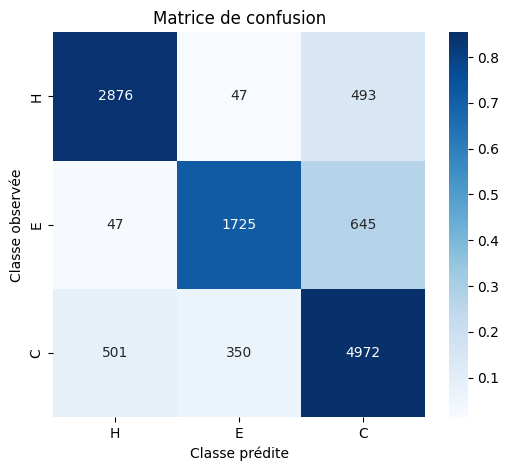

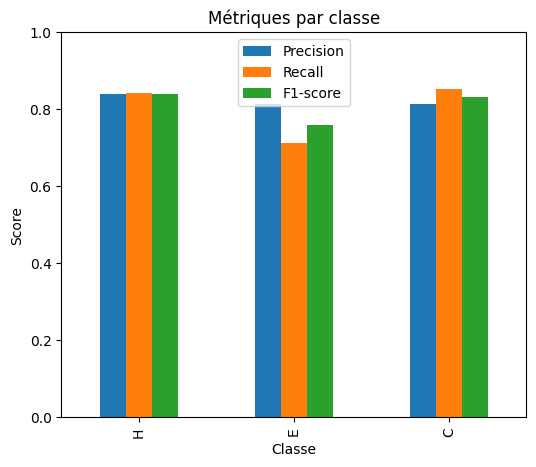

In [ ]:
#Affichage des métriques 

_, y_test_true, y_test_pred = evaluate(model, test_loader, loss_fn, device)


print("Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test_true, y_test_pred))
print("Macro F1:", f1_score(y_test_true, y_test_pred, average='macro'))
print("\nClassification report:")
print(classification_report(y_test_true, y_test_pred, labels=[0,1,2]))  # H=0, E=1, C=2

print("\nConfusion matrix :")
print(confusion_matrix(y_test_true, y_test_pred, labels=[0,1,2]))

# Matrice de confusion et heatmap
classes = ['H', 'E', 'C']
cm = confusion_matrix(y_test_true, y_test_pred, labels=[0,1,2])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Classe observée')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion')
plt.show()

# Métriques par classe
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_true, y_test_pred, labels=[0,1,2]
)

df_metrics = pd.DataFrame({
    'Classe': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

df_metrics.plot(x='Classe', kind='bar', figsize=(6,5))
plt.ylim(0,1)
plt.title('Métriques par classe')
plt.ylabel('Score')
plt.show()
